In [2]:
#coding: utf-8

import warnings
warnings.simplefilter("ignore")

import os
import sys 
import wave
import time
import librosa
import numpy as np
import seaborn as sns
from utils import *
import matplotlib.pyplot as plt
from StringIO import StringIO

%pylab inline

# sudo pip install librosa
# ubuntu: sudo apt-get install libav-tools
# OSX   : brew install libav OMP_NUM_THREADS=2

Populating the interactive namespace from numpy and matplotlib


# Get the Data

Датасет для контеста помещен вот здесь: https://yadi.sk/d/3jmeVCfSwTKgm (внимание! файл весит 3,5 Гб)


Он распаковывается в папку "musicdata". Все пути в этом ноутбуке будут относительно этой папки: "./musicdata/\*". 

Вы можете изменить базовый путь, как вам удобно.

In [3]:
BP = "./musicdata/"

# Just a Sound

Для начала попробуем поработать со звуком - послушайте любой трек, постройте график сырых данных и спектрограмму.

In [4]:
import IPython
from IPython import display

def Audio(url):
    return display.HTML("<center><audio controls><source src='{}' type=\"audio/wav\"></audio>".format(url))

In [5]:
sound_file = os.path.join(BP, "audiosamples", "short_206377.wav")
#sound_file = BP + "audiosamples/short_206377.wav"
y, sr = librosa.load(sound_file)

Audio(url=sound_file)

In [6]:
x = np.zeros(y.size)
for i in range(1,size(x)):
    x[i] = x[i-1]+1./sr

# Sound as 1D-Signal

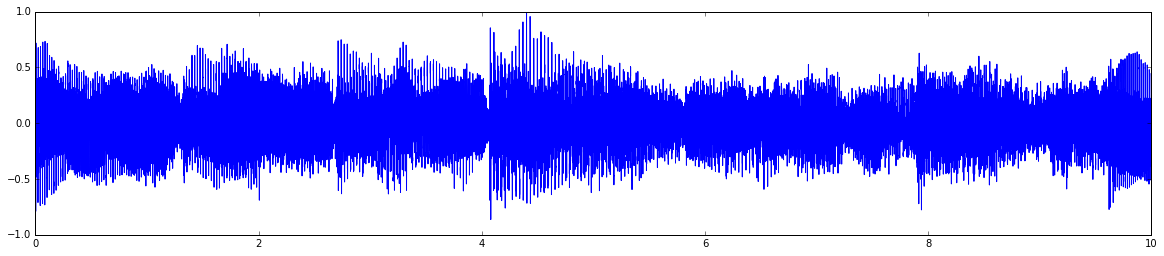

In [7]:
plt.figure(figsize=(20,4))
pylab.plot(x,y)
pylab.xlim([0, 10])
pylab.show()

# Sound as 2D-Signal

Нашу цель слелать из предыдущего графика картинку - для этого нам нужно оценить частоты в каждый момент времени. Благо за нас это умеет делать librosa, у которой внутри STFFT. Используйте librosa.feature.melspectrogram -- для получения спектрограммы, и librosa.logamplitude для выравнивания диапазонов частот. 

help: https://gist.github.com/mailletf/3484932dd29d62b36092

In [8]:
S = librosa.feature.melspectrogram(y,sr=sr,n_mels=128)
log_S = librosa.logamplitude(S, ref_power=np.max)

Нарисуйте спектрограмму, получилась красивая картинка?

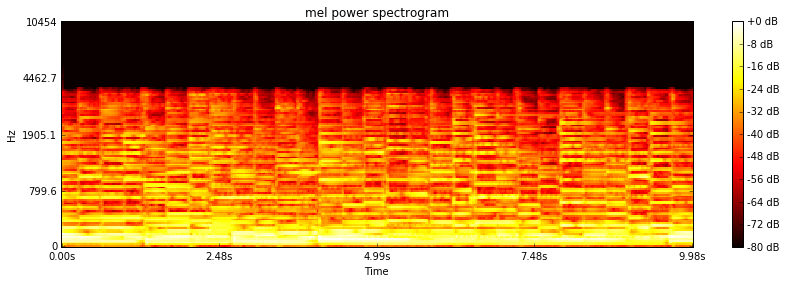

In [9]:
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='hot')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

# Prepare the Data

В этой секции мы создадим датасет, прочитав все данные.

In [10]:
files = os.listdir(os.path.join(BP,"spectrograms"))
sorted_files = sorted(files)
trainfiles = sorted_files[:-1]
print trainfiles

['spectrograms1.pcl', 'spectrograms2.pcl', 'spectrograms3.pcl', 'spectrograms4.pcl', 'spectrograms5.pcl', 'spectrograms6.pcl']


In [13]:
import numpy as np
print "loading file: ", trainfiles[0]
X = np.load(os.path.join(BP, "spectrograms", trainfiles[0]), mmap_mode = 'r')
for trainfile in trainfiles[1:]:
    print "loading file: ", trainfile
    X = np.append(X, np.load(os.path.join(BP, "spectrograms", trainfile), mmap_mode = 'r'), axis = 0)

# X = np.load(os.path.join(BP, "spectrograms", trainfiles[0]))
print shape(X)

loading file:  spectrograms1.pcl
loading file:  spectrograms2.pcl
loading file:  spectrograms3.pcl
loading file:  spectrograms4.pcl
loading file:  spectrograms5.pcl
loading file:  spectrograms6.pcl
(12000, 128, 431)


Здесь вы должны получить train genres. Они идут подряд в соответствии с последовательностью треков в файлах с данными. Для содержимого первых шести файлов у вас есть жанры, а для последнего файла, вам их нужно предсказать.

In [14]:
f_in = open(os.path.join(BP, "train_genres.txt"), "rt")
y_lines = []
for line in f_in:
    y_lines.append(line)
print size(y_lines)

12000


In [15]:
train_genres = y_lines
for i in range(len(train_genres)):
    train_genres[i] = train_genres[i][:-1]
train_genres
genres_set = set(train_genres)
num_classes = len(genres_set)
numbers = [i for i in range(num_classes)]
genres_map = dict(zip(genres_set, numbers))


In [16]:
train = np.zeros(len(train_genres))
for i in range(len(train_genres)):
    train[i] = int(genres_map[train_genres[i]])
print genres_map
print train_genres[:10]
print train[:10]

{'balkan': 66, 'spiritual': 0, 'industrial': 1, 'punk': 56, 'classical': 2, 'reggae': 34, 'dance': 4, 'rusrap': 5, 'modern': 6, 'pop': 7, 'latinfolk': 65, 'dubstep': 8, 'bard': 9, 'rap': 10, 'blues': 17, 'sport': 12, 'conjazz': 13, 'meditation': 11, 'folk': 15, 'tradjazz': 16, 'dnb': 18, 'trance': 19, 'dub': 20, 'relax': 37, 'children': 22, 'lounge': 23, 'indie': 24, 'other': 25, 'ska': 26, 'eurofolk': 27, 'house': 28, 'prog': 29, 'electronics': 30, 'holiday': 31, 'newage': 32, 'urban': 3, 'alternative': 14, 'reggaeton': 35, 'estrada': 36, 'eastern': 21, 'jewish': 38, 'rnb': 39, 'rock': 62, 'jazz': 40, 'spoken': 33, 'soundtrack': 43, 'amerfolk': 44, 'shanson': 45, 'ukrrock': 42, 'rusfolk': 47, 'rnr': 48, 'hardcore': 49, 'bollywood': 51, 'rusrock': 52, 'funk': 53, 'celtic': 54, 'country': 55, 'metal': 41, 'soul': 57, 'vocal': 58, 'disco': 59, 'techno': 60, 'african': 46, 'asiapop': 63, 'newwave': 64, 'musical': 50, 'experimental': 61}
['bard', 'dance', 'relax', 'rock', 'rap', 'soundtrac

# Nearest Neighbors genre classification

Let's try to solve similarity task by the nearest neighbour approach.

<img src="./img/nn.png" width="300">

Перемешаем датасет - используйте `np.random.permutation` и индексацию `a[np.random.permutation]`.

In [18]:
y = train_genres
perm = np.random.permutation(len(y))
X = X[perm]
y = train[perm]
# Xreshape = X.reshape(X.shape[0], X.shape[1], X.shape[2])

MemoryError: 

Разобьем датасет на трейн и валидацию 80/20%.

In [ ]:
Xreshape = Xperm.reshape((Xperm.shape[0], Xperm.shape[1]* Xperm.shape[2]))
print shape(Xreshape)

In [ ]:

X_train, X_valid = Xreshape[:1800], Xreshape[1800:]
y_train, y_valid = y[:1800], y[1800:]

Попробуем поклассифицировать жанры методом ближайших соседей.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
# y_val_pred = clf.predict(X_valid.reshape((X_valid.shape[0], -1)))

print accuracy_score(y_valid, y_pred)

# Fully-Connected Neural Nets

Использовать нейросети - это хорошая идея, давайте начнем с полносвязных сетей.

In [ ]:
import theano
import lasagne
import theano.tensor as T

from utils3 import train_net

Перемешаем и разобьем датасет.

In [ ]:
print shape(X)

In [ ]:
perm = np.random.permutation(len(y))
X2, y = np.array(X)[perm].astype('float32'), np.array(train)[perm]
Xreshape = X2.reshape(X2.shape[0], 1, X2.shape[1], X2.shape[2])

X_train, X_valid = Xreshape[:1800], Xreshape[1800:]
y_train, y_valid = y[:1800], y[1800:]

In [ ]:
Xreshape = Xperm.reshape(X.shape[0], 1, X.shape[1], X.shape[2])
X_train, X_valid = Xreshape[:1800], Xreshape[1800:]
y_train, y_valid = y[:1800], y[1800:]

In [ ]:
from lasagne.layers import DenseLayer, InputLayer

In [ ]:
input_X, target_y = T.tensor4("X", dtype='float32'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, 1, X2.shape[1], X2.shape[2]), input_var=input_X) 
a1 = lasagne.layers.DenseLayer(nn, 56)
a2 = lasagne.layers.DenseLayer(a1, 56)
a3  = lasagne.layers.DenseLayer(a2, 56)
y_predicted = lasagne.layers.get_output(a3)
all_weights = lasagne.layers.get_all_params(a3)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.nesterov_momentum(loss,all_weights,0.9 )

In [ ]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)

In [ ]:
%time conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=10, batch_size=50)

# Convolution Neural Nets

Да, вероятно, полносвязные сети не зажгли и kNN не обогнали. Давайте попробуем сверточные, хороший вариант делать одномерные свертки (сразу по всем частотам). Хотя двумерные тоже могут работать. 

Архитектуру можно подсмотреть [тут](http://benanne.github.io/2014/08/05/spotify-cnns.html).

In [14]:
import theano
import lasagne
import theano.tensor as T

from utils3 import train_net

In [17]:
perm = np.random.permutation(len(y))
X3, y = np.array(X)[perm].astype('float32'), np.array(train)[perm]
Xreshape = X3.reshape(X3.shape[0], X3.shape[1], X3.shape[2])

X_train, X_valid = Xreshape[:1800], Xreshape[1800:]
y_train, y_valid = y[:1800], y[1800:]

MemoryError: 

In [18]:
print train

[  9.   4.  33. ...,   7.  32.   7.]


In [ ]:
input_X, target_y = T.tensor3("X", dtype='float64'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, X.shape[1], X.shape[2]), input_var=input_X) 
conv1 = lasagne.layers.Conv1DLayer(nn, 4, 4)
maxp1 = lasagne.layers.MaxPool1DLayer(conv1, 2)
dens1 = lasagne.layers.DenseLayer(maxp1, 56)
# nn = ??? Сделайте свою сеть, используя: Conv1DLayer + MaxPool1DLayer + DenseLayer

finale = lasagne.layers.DenseLayer(dens1, num_classes, nonlinearity=lasagne.nonlinearities.softmax)

In [ ]:
y_predicted = lasagne.layers.get_output(finale)
all_weights = lasagne.layers.get_all_params(finale)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.adam(loss, all_weights)

In [ ]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)

In [ ]:
# Подумайте, какой размер батча нужен и сколько эпох вы можете себе позволить подождать
%time conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=10, batch_size=10)

Валидационная точность должна быть около 0.6 или лучше. 

Давайте нарисуем каждый второй фильтр - можете ли вы проинтерпретировать эти фильтры?

In [ ]:
plt.figure(figsize=(5, 5), dpi=500)
W = lasagne.layers.get_all_params(finale)[0].get_value()
W[::2, :, :] = 0.2
W = np.hstack(W)
pylab.imshow(W, cmap='hot', interpolation="nearest")
pylab.axis('off')
pylab.show()

# Maps of tracks by SVD and tSNE

Хорошая идея посмотреть, как полученое представление отображается с сохранением относительных расстояний на плоскость. Используйте tSNE или PCA.

Help: https://lts2.epfl.ch/blog/perekres/category/visualizing-hidden-structures-in-datasets-using-deep-learning/

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
represent = lasagne.layers.get_output(finale.input_layer)
represent_fun = theano.function([input_X], [represent], allow_input_downcast=True)

In [ ]:
f = lambda x: np.array(represent_fun([x])[0])
track_vectors = map(f, X_train) + map(f, X_valid)
track_vectors = np.concatenate(track_vectors, axis=0)

track_labels = np.array(list(y_train) + list(y_valid))

получите 2d вектора

In [ ]:
X_tsne = ????

нарисуйте получившиеся точки

In [ ]:
plt.figure(figsize=(10,10), dpi=500)
colors = cm.hot(np.linspace(0, 1, len(id2gener)))

for idx, gener in id2gener.items():
    idx_ = np.where(track_labels == idx)
    pylab.scatter(????, ????, c=colors[idx], cmap=cm.hot, label=gener,s=50)

pylab.legend(loc=0, ncol=5)